# Breast-Ultrasound-Segmentation

## About Dataset
Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

### Data
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

If you use this dataset, please cite:
Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}"

In [2]:
import torch

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


In [3]:
from pathlib import Path

import cv2
import hydra
import opendatasets as od
from hydra import compose, initialize

## Paths setup

In [4]:
from omegaconf import DictConfig

with initialize(config_path="../configs", job_name="EDA", version_base=None):
    cfg: DictConfig = compose(config_name="train.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}'}


In [5]:
# # auto reload dotenv
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

In [6]:
ROOT_DIR = Path(cfg.paths.root_dir)
DATASET_URL = cfg.data.url
ROOT_DATA_DIR = Path(cfg.paths.root_data_dir)
DATA_DIR = ROOT_DATA_DIR / cfg.data.dataset_dir
DATA_DIR

PosixPath('/workspaces/PyTorch-Breast-Ultrasound-Segmentation/data/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT')

In [7]:
os.chdir(root)

## Download Datasets

In [8]:
if len(list(ROOT_DATA_DIR.iterdir())) == 0:
    print("Downloading dataset from kaggle...")
    od.download(dataset_id_or_url=DATASET_URL, data_dir=str(ROOT_DATA_DIR))

## Data Loading

In [9]:
import matplotlib.pyplot as plt
from torchvision import io

In [10]:
image = io.read_image(str(DATA_DIR / "benign/benign (1).png"))
mask_path = io.read_image(str(DATA_DIR / "benign/benign (1)_mask.png"))
image.shape

torch.Size([3, 471, 562])

In [11]:
cv2.imread(str(DATA_DIR / "benign/benign (1).png")).shape

(471, 562, 3)

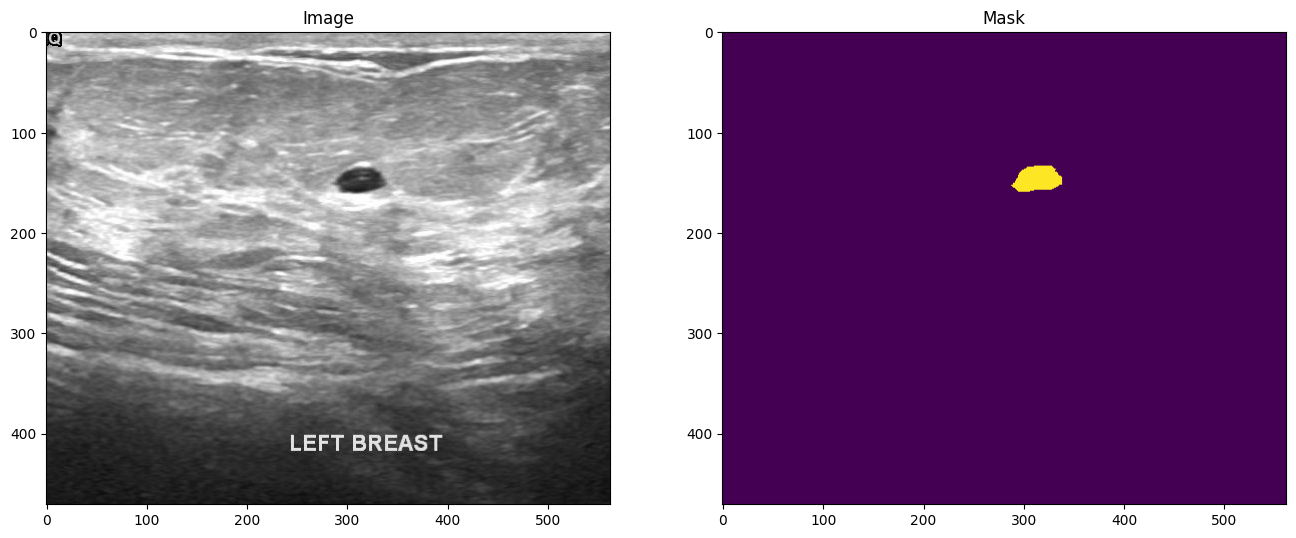

In [12]:
image = io.read_image(str(DATA_DIR / "benign/benign (1).png"))
mask_path = io.read_image(str(DATA_DIR / "benign/benign (1)_mask.png"))
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask_path.permute(1, 2, 0))

## Dataloader

In [13]:
org_images = []
masks = []
labels = []

for _dir in DATA_DIR.iterdir():
    dir_name = _dir.stem
    img_nums = (img.stem.split("(")[-1].split(")")[0] for img in _dir.glob("*.png"))
    for num in img_nums:
        # normal (1).png
        img_path = f"{_dir/dir_name} ({num})"
        org_img_path = Path(f"{img_path}.png")
        # normal (2)_mask
        mask_path = Path(f"{img_path}_mask.png")
        org_images.append(org_img_path)
        labels.append(dir_name)
        masks.append(mask_path)
print(org_images[10])
print(masks[10])
print(labels[10])

/workspaces/PyTorch-Breast-Ultrasound-Segmentation/data/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (118).png
/workspaces/PyTorch-Breast-Ultrasound-Segmentation/data/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (118)_mask.png
normal


In [14]:
data = {"images": org_images, "masks": masks, "labels": labels}

import pandas as pd

df = pd.DataFrame(data)
df

,images,masks,labels
0,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,normal
1,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,normal
2,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,normal
3,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,normal
4,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,normal
...,...,...,...
1573,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,benign
1574,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,benign
1575,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,benign
1576,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,/workspaces/PyTorch-Breast-Ultrasound-Segmenta...,benign


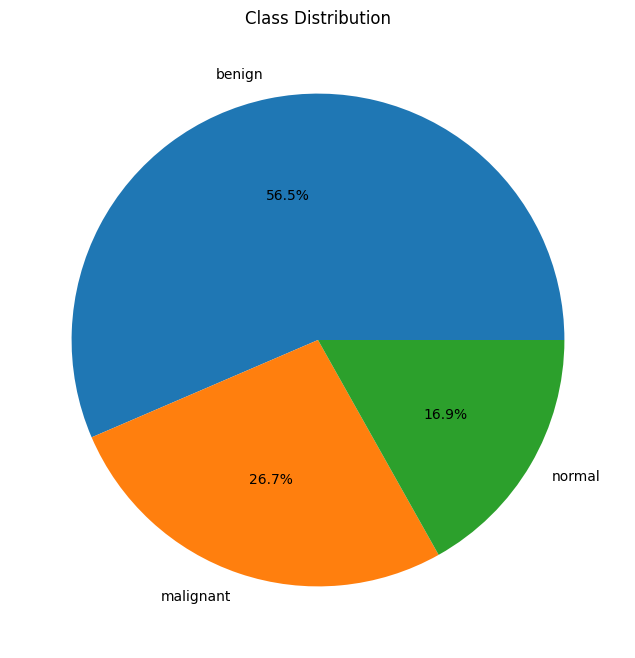

In [15]:
plt.figure(figsize=(16, 8))
plt.pie(df["labels"].value_counts(), labels=df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Class Distribution")
plt.show()

In [16]:
label_mapping = {label: i for i, label in enumerate(sorted(set(labels)))}
label_mapping

{'benign': 0, 'malignant': 1, 'normal': 2}

In [17]:
cfg.datamodule

{'data': {'dataset': {'_target_': 'src.datamodules.components.breast_cancer_dataset.BreastCancerDataset', 'data_dir': '${data.dataset_dir}', 'dataset_url': '${data.url}'}, 'dataset_name': 'breast-ultrasound-images-dataset', 'dataset_dir': 'data/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', 'url': 'https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset'}, '_target_': 'src.datamodules.breast_cancer_dataloader_module.BreastCancerDataLoaderModule', 'transforms': {'train_transforms': [{'_target_': 'torchvision.transforms.v2.Resize', 'size': [256, 256], 'antialias': True}, {'_target_': 'torchvision.transforms.v2.RandomHorizontalFlip'}, {'_target_': 'torchvision.transforms.v2.RandomVerticalFlip'}, {'_target_': 'torchvision.transforms.v2.ElasticTransform', 'alpha': 50.0, 'sigma': 5.0}], 'val_transforms': [{'_target_': 'torchvision.transforms.v2.Resize', 'size': [256, 256]}], 'test_transforms': [{'_target_': 'torchvision.transforms.v2.Resize', 'size': [256, 256]}]

In [18]:
from torchvision.utils import draw_segmentation_masks

data_module = hydra.utils.instantiate(cfg.datamodule)
dataset = data_module.dataset  # already initialized BreastCancerDataset

In [19]:
inv_label_mapping = {v: k for k, v in dataset.label_mapping.items()}

In [20]:
print(dataset.labels)
for image, target in dataset:
    print(image.shape, image.min(), image.max())
    print(target["labels"].shape)
    print(target["masks"].shape, target["masks"].min(), target["masks"].max())

    break

['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',

In [21]:
dataset.num_classes, "-----------------------", dataset.label_mapping

(3, '-----------------------', {'normal': 0, 'malignant': 1, 'benign': 2})

In [22]:
import random

org_images, masks, labels = dataset.get_data()

num_images = len(org_images)
num_list = list(range(num_images))
random.shuffle(num_list)

## Data Visalization

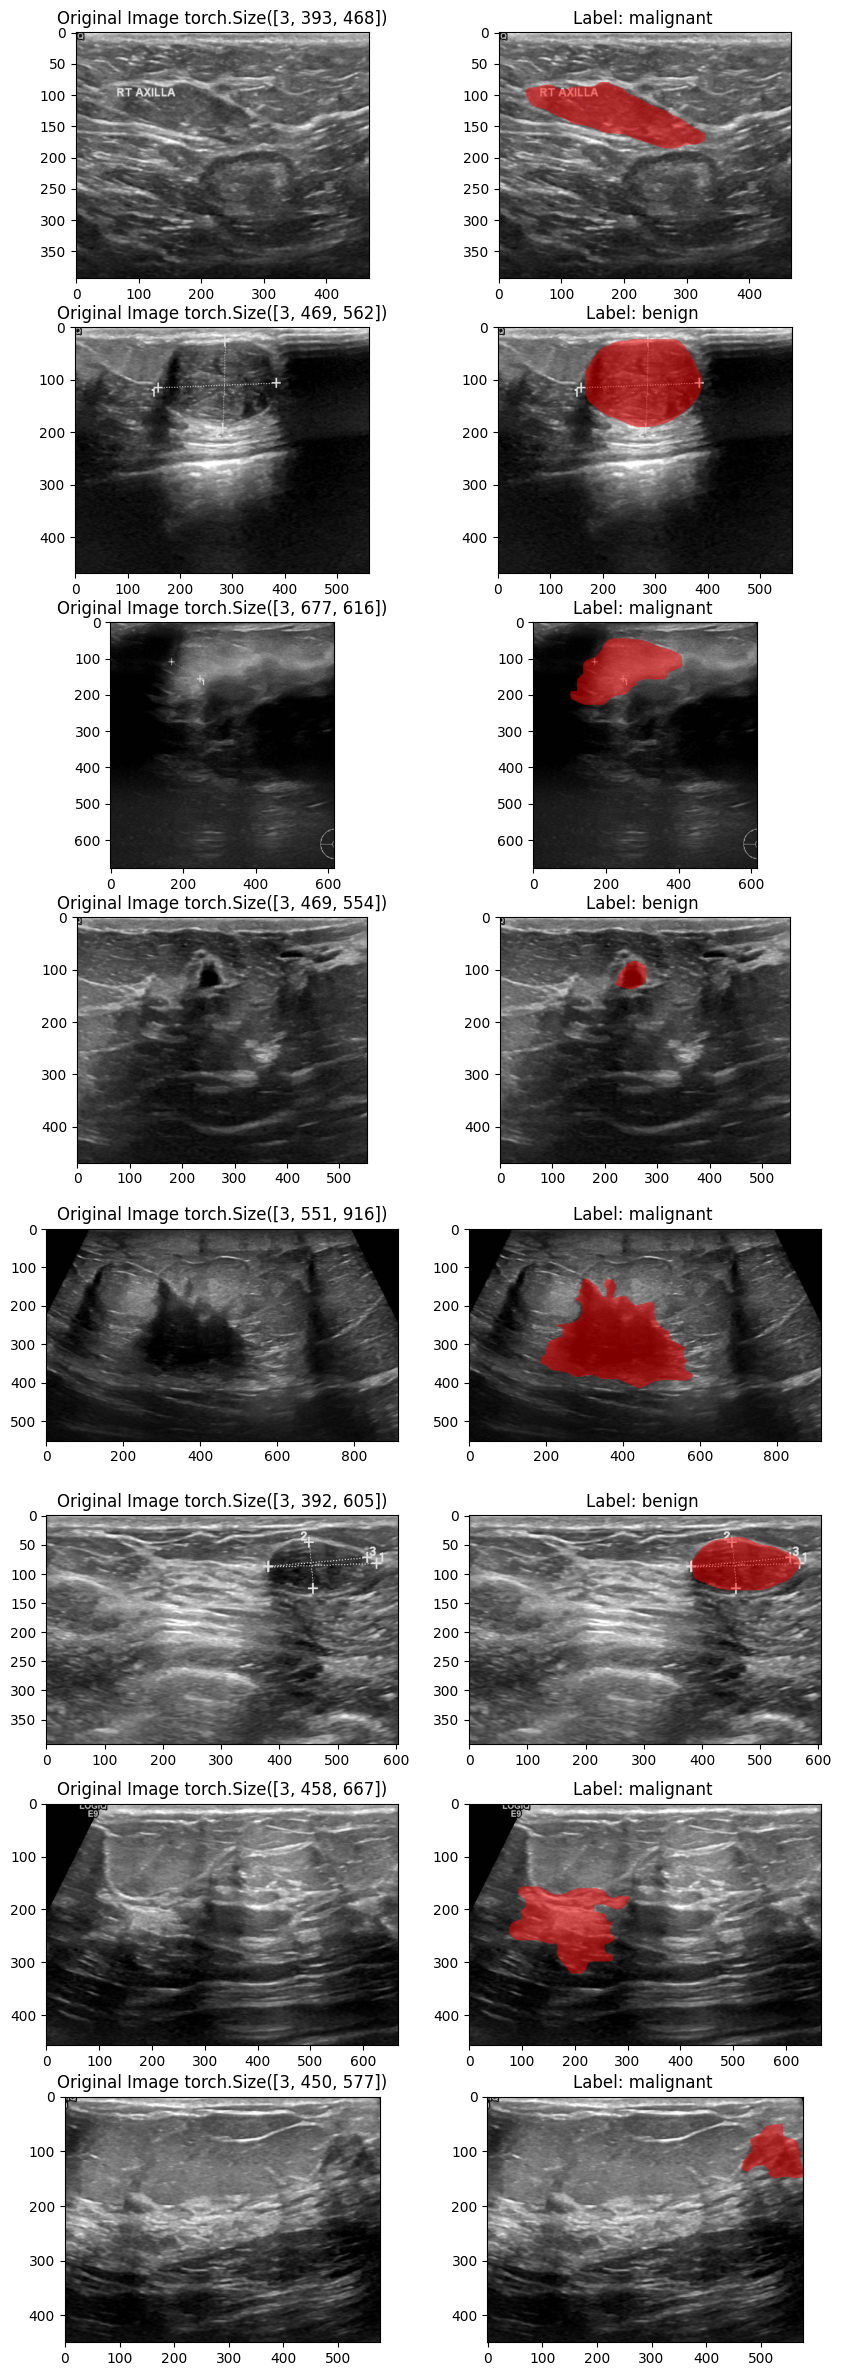

In [23]:
random.shuffle(num_list)
fig, axs = plt.subplots(8, 2, figsize=(10, 30))
for i, ran_idx in enumerate(num_list[:8]):
    # image = image.permute(1, 2, 0)
    image = io.read_image(str(org_images[ran_idx]))
    # Plot the original image on the left
    axs[i, 0].imshow(image.permute(1, 2, 0))
    axs[i, 0].set_title(f"Original Image {image.shape}")
    mask = io.read_image(str(masks[ran_idx]))

    mask_bool = mask > 0.5  # convert mask to bool
    seg_img = draw_segmentation_masks(image, mask_bool, alpha=0.5, colors="red")
    axs[i, 1].imshow(seg_img.permute(1, 2, 0))
    axs[i, 1].set_title(f"Label: {labels[ran_idx]} ")

In [25]:
for image, target in data_module.train_dataset:
    print(image.shape, image.dtype, image.min(), image.max())
    print(target["labels"].shape)
    print(
        target["masks"].shape, target["masks"].dtype, target["masks"].min(), target["masks"].max()
    )
    break

torch.Size([3, 468, 573]) torch.float32 tensor(0.) tensor(1.)
torch.Size([3])
torch.Size([1, 468, 573]) torch.float32 tensor(0.) tensor(1.)


In [27]:
train_dl = data_module.train_dataloader()

for image, target in train_dl.dataset:
    print(image.shape, image.dtype, image.min(), image.max())
    print(target["labels"].shape)
    print(
        target["masks"].shape, target["masks"].dtype, target["masks"].min(), target["masks"].max()
    )
    break

torch.Size([3, 256, 256]) torch.float32 tensor(0.) tensor(0.9987)
torch.Size([3])
torch.Size([1, 256, 256]) torch.float32 tensor(0.) tensor(1.0000)


In [30]:
train_dl.dataset

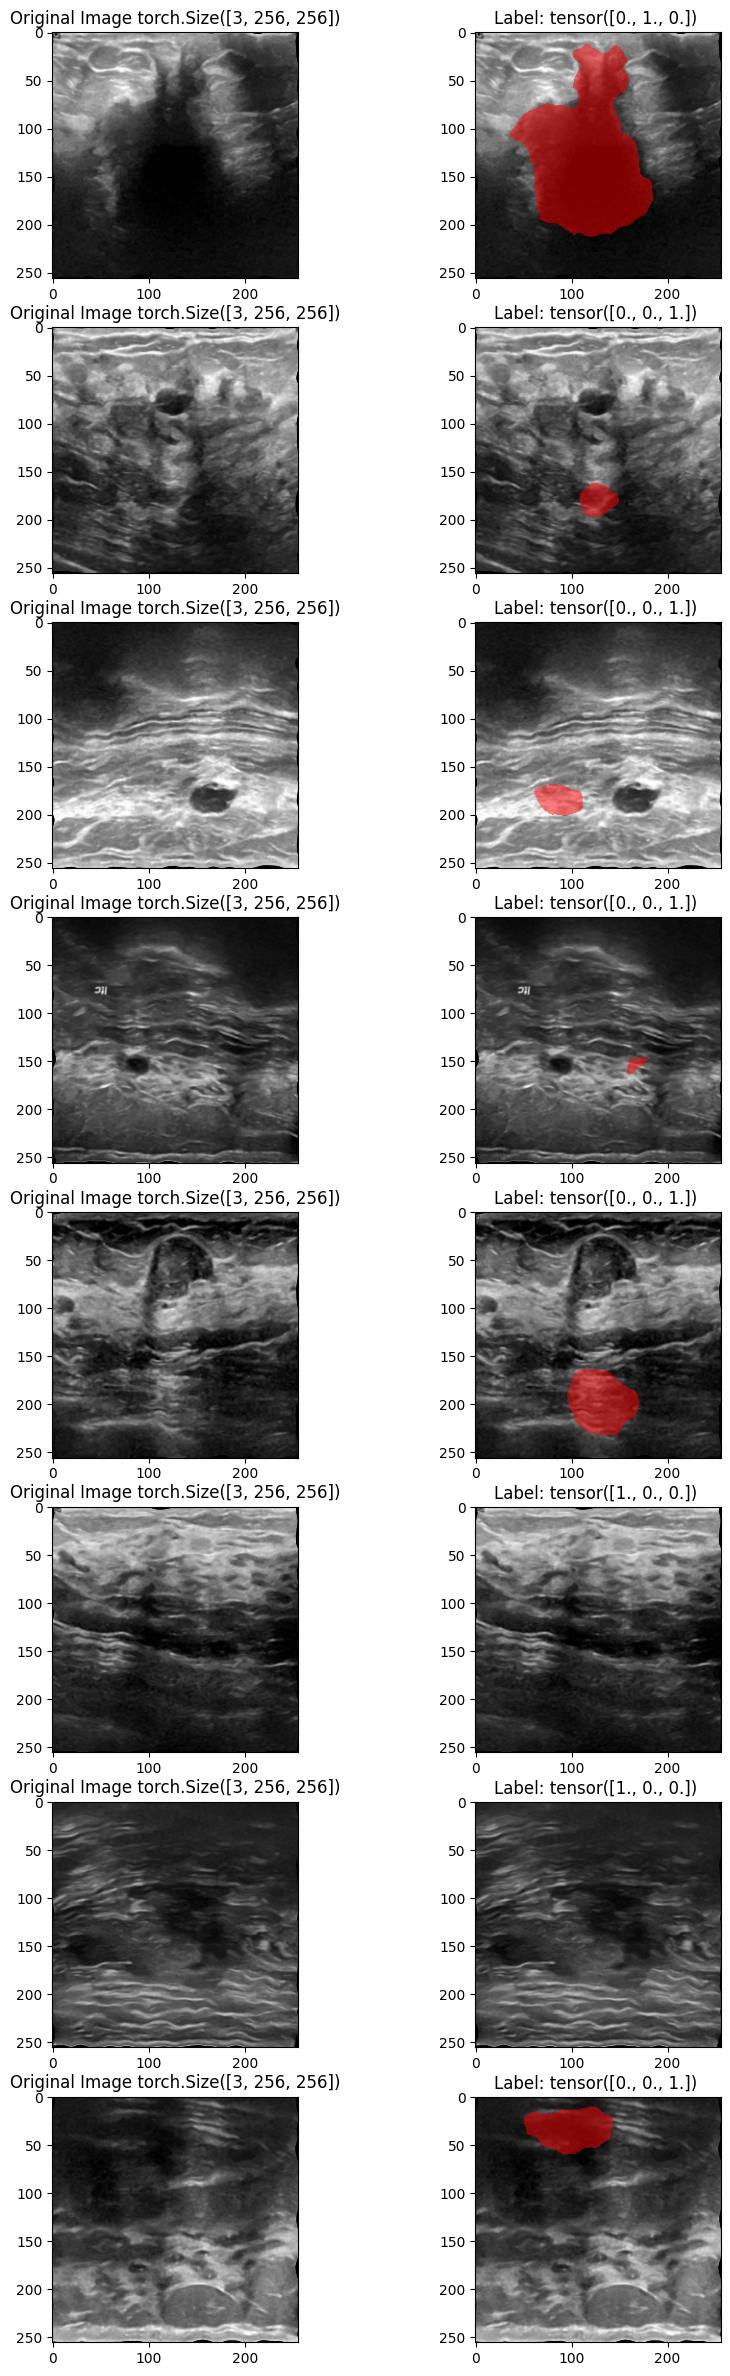

In [34]:
fig, axs = plt.subplots(8, 2, figsize=(10, 30))

for i, (image, target) in enumerate(train_dl.dataset):
    if i >= 8:
        break
    # Plot the original image on the left
    axs[i, 0].imshow(image.permute(1, 2, 0))
    axs[i, 0].set_title(f"Original Image {image.shape}")

    mask_bool = target["masks"] > 0.5  # convert mask to bool
    seg_img = draw_segmentation_masks(image, mask_bool, alpha=0.5, colors="red")
    axs[i, 1].imshow(seg_img.permute(1, 2, 0))
    label = target["labels"]
    axs[i, 1].set_title(f"Label: {label} ")